In [4]:
import os 
from glob import glob
from functools import reduce

import numpy as np
import jax
import jax.numpy as jnp

import xarray as xr
import pandas as pd
import dask

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import cartopy.feature as cfeature
import nc_time_axis
import cftime

from utils.parallel_axis import custom_parallel_coordinates
from utils.param_names import param_names
from utils.param_bounds import params_lower, params_upper
from utils.initial_params import constants, initial_params
from utils.global_paths import project_data_path, project_code_path
from src.read_inputs import read_hindcast_inputs
from src.prediction import make_prediction_vmap

In [5]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5
obs_colors = {'SMAP':"#e7298a", 'VIC':"#d95f02", 'NOAH':"#7570b3", 'MOSAIC':"#1b9e77"}

In [3]:
############
### Dask ###
############
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="20GiB",
    walltime="01:00:00"
)
cluster.scale(jobs=30)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.0.60:35943,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Preliminaries

In [6]:
def get_training_res(subset_name, obs_name, loss_metric, metrics_include, best_metric):
    """
    Reads the training results
    """
    # Loop through files
    files = glob(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/training_res/*.txt')

    df_out = []
    for file in files:
        # Read
        df = pd.read_csv(file, sep = ' ').dropna(how='any')
        df['epoch'] = df['epoch'].astype(np.float32)

        # Add identifiers
        _, param_id, val_id, _ = file.split('/')[-1].split('_')
        df['param_id'] = param_id
        df['val_id'] = val_id
        
        # Take best
        df_best = df.query('epoch > 10').sort_values(by=loss_metric).iloc[:1]
        if len(df_best) > 0:
            df_out.append(df_best)

    # Join
    df_out = pd.concat(df_out).reset_index().drop(columns='index')

    # Filter best result for each metric
    if best_metric:
        metric_min_inds = df_out.groupby('metric')[loss_metric].idxmin()
        df_out = df_out.loc[metric_min_inds].reset_index().drop(columns='index')

    # Subset metrics 
    if metrics_include != 'all':
        df_out = df_out[df_out['metric'].isin(metrics_include)]

    # Return
    return df_out

In [7]:
def simulate_hindcast(subset_name, obs_name, theta):
    """
    Simulates soil moisture from given parameter set
    """
    
    # Get simulation output
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_hindcast_inputs(subset_name, obs_name, False)

    out = make_prediction_vmap(
        theta,
        constants,
        x_forcing_nt,
        x_forcing_nyrs,
        x_maps
        )

    # Construct xr 
    nldas_lats = np.load(f"{project_code_path}/code/utils/grids/{subset_name}_lat.npy")
    nldas_lons = np.load(f"{project_code_path}/code/utils/grids/{subset_name}_lon.npy")
    nt = out.shape[1]

    ds_sim = xr.Dataset(
        data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(out.reshape(len(nldas_lons), len(nldas_lats), nt), (2,1,0)))),
        coords=dict(
            lon=nldas_lons,
            lat=nldas_lats,
            time=xr.cftime_range(start='2016-01-01', end='2022-12-31', calendar='365_day')))

    return ds_sim

## Get hindcasts and calibration statistics

In [2]:
metrics_include = ['kge', 'nse', 'taylor',
                   'rmse', 'ubrmse',
                   'mae', 'ubmae', 
                   'mse', 'ubmse',
                   'outer20rmse', 'outer20ubrmse',
                   'outer50rmse', 'outer50ubrmse']

### Hindcasts

In [13]:
# Add identifiers and store
def store_sim(ds_sim, mask, subset_name, obs_name, sim_id, save_dir):
    # Use 100 as threshold for NaNs outside mask
    if ds_sim['soilMoist'].isnull().any(dim='time').where(mask).sum() > 100.:
        print(f'NaNs found in {obs_name} {sim_id}')
        return None
    
    # Store
    ds_sim = ds_sim.assign_coords(sim_id=sim_id)
    ds_sim.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/{sim_id}.nc",
                     encoding = {"soilMoist": {"zlib": True, "complevel": 2}})

In [14]:
%%time
################
# DASK
################
# Simulate all outputs to make reading easier
subset_name = 'eCONUS'
loss_metric = 'pred_loss'

best_metric = True
save_dir = 'best_only'

delayed = []

for obs_name in ['SMAP', 'VIC', 'NOAH', 'MOSAIC']:
    # Get mask
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc')
    mask = ~ds_obs['soilMoist'].isnull().any(dim='time')
    
    # Loop through results
    df_res = get_training_res(subset_name, obs_name, loss_metric, metrics_include, best_metric)
    for idr in range(len(df_res)):
        
        # Identifiers
        sim_id = f"{df_res.iloc[idr]['metric']}_{df_res.iloc[idr]['param_id']}_{df_res.iloc[idr]['val_id']}"
        file = f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/{sim_id}.nc"
        
        # Check if done
        if not os.path.exists(file):
            # Get theta
            theta = jnp.array([df_res.iloc[idr][param] for param in param_names])
            # Simulate
            ds_sim = dask.delayed(simulate_hindcast)(subset_name, obs_name, theta)
            # Store
            delayed.append(dask.delayed(store_sim)(ds_sim, mask, subset_name, obs_name, sim_id, save_dir))

# Compute
print(len(delayed))
_ = dask.compute(*delayed)

52
CPU times: user 19.1 s, sys: 3.13 s, total: 22.2 s
Wall time: 3min 22s


### Single prediction statistics

In [35]:
##################################
# All calibration statistics
# we might be interested in
##################################

def _rmse(ds, ds_obs, save_name, subset_name, obs_name, save_dir):
    rmse = np.sqrt(((ds - ds_obs)**2).mean(dim="time"))
    ds_rmse = xr.Dataset({"rmse":rmse})
    ds_rmse.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/stats/rmse_{save_name}.nc")

def _ubrmse(ds, ds_obs, save_name, subset_name, obs_name, save_dir):
    ds_centered = ds - ds.mean(dim='time')
    ds_obs_centered = ds_obs - ds_obs.mean(dim='time')
    ubrmse = np.sqrt(((ds_centered - ds_obs_centered)**2).mean(dim="time"))
    ds_ubrmse = xr.Dataset({"ubrmse":ubrmse})
    ds_ubrmse.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/stats/ubrmse_{save_name}.nc")

def _nse(ds, ds_obs, save_name, subset_name, obs_name, save_dir):
    nse = 1 - ((ds_obs - ds) ** 2).sum(dim="time") / ((ds_obs - ds_obs.mean(dim="time")) ** 2).sum(dim="time")
    ds_nse = xr.Dataset({"nse":nse})
    ds_nse.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/stats/nse_{save_name}.nc")

def _kge(ds, ds_obs, save_name, subset_name, obs_name, save_dir):
    corr = xr.corr(ds, ds_obs, dim="time")
    mean_ratio = ds.mean(dim="time")/ds_obs.mean(dim="time")
    std_ratio = ds.std(dim="time")/ds_obs.std(dim="time")
    kge = 1 - np.sqrt((corr - 1) ** 2 + (mean_ratio - 1) ** 2 + (std_ratio - 1) ** 2)
    ds_kge = xr.Dataset({"kge":kge})
    ds_kge.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/stats/kge_{save_name}.nc")

def _ac(ds, ds_obs, save_name, subset_name, obs_name, save_dir):
    ds_centered = ds - ds.mean(dim='time')
    ds_obs_centered = ds_obs - ds_obs.mean(dim='time')
    ac = xr.corr(ds_centered, ds_obs_centered, dim="time")
    ds_ac = xr.Dataset({"ac":ac})
    ds_ac.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/stats/ac_{save_name}.nc")

def _taylor(ds, ds_obs, save_name, subset_name, obs_name, save_dir):
    corr = xr.corr(ds, ds_obs, dim="time")
    std_ratio = ds.std(dim="time")/ds_obs.std(dim="time")
    R0 = 1.0
    taylor = 4 * (1 + corr) / (((std_ratio + 1 / std_ratio) ** 2) * (1 + R0))
    ds_taylor = xr.Dataset({"taylor":taylor})
    ds_taylor.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/stats/taylor_{save_name}.nc")

def _mse(ds, ds_obs, save_name, subset_name, obs_name, save_dir):
    mse = ((ds - ds_obs)**2).mean(dim="time")
    ds_mse = xr.Dataset({"mse":mse})
    ds_mse.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/stats/mse_{save_name}.nc")

def _mae(ds, ds_obs, save_name, subset_name, obs_name, save_dir):
    mae = (np.abs(ds - ds_obs)).mean(dim="time")
    ds_mae = xr.Dataset({"mae":mae})
    ds_mae.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/stats/mae_{save_name}.nc")

def _outer50rmse(ds, ds_obs, save_name, subset_name, obs_name, save_dir):
    inds = (ds_obs <= ds_obs.quantile(0.25, dim='time')) | (ds_obs >= ds_obs.quantile(0.75, dim='time'))
    outer50rmse = np.sqrt(((ds.where(inds) - ds_obs.where(inds))**2).mean(dim="time"))
    ds_outer50rmse = xr.Dataset({"outer50rmse":outer50rmse})
    ds_outer50rmse.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/stats/outer50rmse_{save_name}.nc")

def _outer20rmse(ds, ds_obs, save_name, subset_name, obs_name, save_dir):
    inds = (ds_obs <= ds_obs.quantile(0.1, dim='time')) | (ds_obs >= ds_obs.quantile(0.9, dim='time'))
    outer20rmse = np.sqrt(((ds.where(inds) - ds_obs.where(inds))**2).mean(dim="time"))
    ds_outer20rmse = xr.Dataset({"outer20rmse":outer20rmse})
    ds_outer20rmse.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{save_dir}/stats/outer20rmse_{save_name}.nc")

In [39]:
# List
stat_funcs = {'rmse':_rmse,
              'mse':_mse,
              'mae':_mae,
              'kge':_kge,
              'ubrmse':_ubrmse,
              'nse':_nse,
              'taylor':_taylor,
              'outer50rmse':_outer50rmse,
              'outer20rmse':_outer20rmse}

In [40]:
#############################################
# Calculate calibration stats for hindcasts
#############################################
def get_calibration_stats(subset_name, obs_name, stats, hindcast_dir, save_name):
    # Read all sims
    files = glob(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/*.nc")
    files = [file for file in files if file.split('/')[-1].split('_')[0] in metrics_include]
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='sim_id')
    ds['sim_id'].encoding["dtype"] = "S1"
    ds = ds['soilMoist'].chunk({'lat':-1, 'lon':-1}).persist()
        
    # Read obs
    ds_obs = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc")['soilMoist']

    # Calculate desired stats
    for stat in stats:
        if not os.path.exists(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/{stat}_{save_name}.nc"):
            stat_func = stat_funcs[stat]
            stat_func(ds, ds_obs, save_name, subset_name, obs_name, hindcast_dir)

In [41]:
%%time

subset_name = "eCONUS"
hindcast_dir = "best_only"
save_name = "best_only"
stats = ["rmse", "mse", "mae", "kge", "nse", "taylor", "outer50rmse", "outer20rmse", "ubrmse"]

for obs_name in ["SMAP", "VIC", "NOAH", "MOSAIC"]:
    get_calibration_stats(subset_name=subset_name,
                          obs_name=obs_name,
                          stats=stats,
                          hindcast_dir=hindcast_dir,
                          save_name=save_name)

/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.17 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 599.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 599.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of 

CPU times: user 27 s, sys: 15.2 s, total: 42.3 s
Wall time: 1min 13s


In [10]:
#############################################
# Calculate calibration stats for obs-obs
#############################################
def get_pairwise_stats(subset_name, obs_1_name, obs_2_name, stats):
    # Read obs
    ds_obs1 = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_1_name}/{obs_1_name}_validation.nc")['soilMoist']
    ds_obs2 = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_2_name}/{obs_2_name}_validation.nc")['soilMoist']

    # Calculate desired stats
    for stat in stats:
        if not os.path.exists(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_1_name}/hindcasts/{stat}_{obs_2_name}.nc"):
            stat_func = stat_funcs[stat]
            stat_func(ds_obs1, ds_obs2, obs_2_name, subset_name, obs_1_name)

In [7]:
%%time
subset_name = "eCONUS"
stats = ["rmse", "mse", "mae", "kge", "nse", "taylor", "outer50rmse", "outer20rmse", "ubrmse"]

for obs_1_name in ["SMAP", "VIC", "NOAH", "MOSAIC"]:
    for obs_2_name in ["SMAP", "VIC", "NOAH", "MOSAIC"]:
        if obs_1_name != obs_2_name:
            get_pairwise_stats(subset_name=subset_name,
                               obs_1_name=obs_1_name,
                               obs_2_name=obs_2_name,
                               stats=stats)

/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return functi

CPU times: user 6min 46s, sys: 2min 50s, total: 9min 37s
Wall time: 10min 6s


### Ensemble statistics

In [7]:
def _crps(ds, ds_obs, save_name, subset_name, obs_name, hindcast_dir):
    crps = xs.crps_ensemble(observations=ds_obs,
                                       forecasts=ds.chunk(dict(sim_id=-1)),
                                       member_dim='sim_id',
                                       dim='time')
    ds_crps = xr.Dataset({"crps":crps})
    ds_crps.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/crps_{save_name}.nc")

def _coverage(ds, ds_obs, save_name, subset_name, obs_name, hindcast_dir):
    # Get max/mins
    ds_maxs = ds.max(dim="sim_id")
    ds_mins = ds.min(dim="sim_id")
    
    # Get coverage
    ds_above = ds_obs > ds_maxs
    ds_below = ds_obs < ds_mins
    coverage = 100 * (1. - (ds_above + ds_below)).mean(dim="time")
    
    # Save
    ds_mins.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/mins_{save_name}.nc",
                     encoding = {"soilMoist": {"zlib": True, "complevel": 2}})
    ds_maxs.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/maxs_{save_name}.nc",
                     encoding = {"soilMoist": {"zlib": True, "complevel": 2}})
    
    ds_coverage = xr.Dataset({'coverage':coverage.where(~ds_maxs.isel(time=1).isnull())})
    ds_coverage.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/coverage_{save_name}.nc")

def _ubcoverage(ds, ds_obs, save_name, subset_name, obs_name, hindcast_dir):
    # Center
    ds_centered = ds - ds.mean(dim='time')
    ds_obs_centered = ds_obs - ds_obs.mean(dim='time')
    
    # Get max/mins
    ds_maxs = ds_centered.max(dim="sim_id")
    ds_mins = ds_centered.min(dim="sim_id")
    
    # Get coverage
    ds_above = ds_obs_centered > ds_maxs
    ds_below = ds_obs_centered < ds_mins
    coverage = 100 * (1. - (ds_above + ds_below)).mean(dim="time")
    
    # Save
    ds_mins.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/centered_mins_{save_name}.nc",
                     encoding = {"soilMoist": {"zlib": True, "complevel": 2}})
    ds_maxs.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/centered_maxs_{save_name}.nc",
                     encoding = {"soilMoist": {"zlib": True, "complevel": 2}})
    
    ds_coverage = xr.Dataset({'coverage':coverage.where(~ds_maxs.isel(time=1).isnull())})
    ds_coverage.to_netcdf(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/ubcoverage_{save_name}.nc")


In [8]:
# List
stat_funcs = {'coverage':_coverage}

In [9]:
#############################################
# Calculate calibration stats for hindcasts
#############################################
def get_calibration_stats(subset_name, obs_name, stats, metrics_include, save_name, hindcast_dir):
    # Read all sims
    files = glob(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/*.nc")
    files = [file for file in files if file.split('/')[-1].split('_')[0] in metrics_include]
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='sim_id')
    ds['sim_id'].encoding["dtype"] = "S1"
    ds = ds['soilMoist'].chunk({'lat':-1, 'lon':-1}).persist()
        
    # Read obs
    ds_obs = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc")['soilMoist']

    # Calculate desired stats
    for stat in stats:
        if not os.path.exists(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/{stat}_{save_name}.nc"):
            stat_func = stat_funcs[stat]
            stat_func(ds, ds_obs, save_name, subset_name, obs_name, hindcast_dir)

In [10]:
%%time

subset_name = "eCONUS"
hindcast_dir = "best_only"

save_name = "best_only"
stats = ["coverage"]

for obs_name in ["SMAP", "VIC", "NOAH", "MOSAIC"]:
    get_calibration_stats(subset_name=subset_name,
                          obs_name=obs_name,
                          stats=stats,
                          metrics_include=metrics_include,
                          hindcast_dir=hindcast_dir,
                          save_name=save_name)

/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.17 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 599.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 599.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of 

CPU times: user 41.7 s, sys: 16 s, total: 57.7 s
Wall time: 3min


In [28]:
%%time
#########################################
# Full coverage: separate calculation
#########################################
subset_name = "eCONUS"
hindcast_dir = "best_only"
save_name = "best_only"

# Read all sims
ds_all = []
for obs_name in ["SMAP", "VIC", "NOAH", "MOSAIC"]:
    files = glob(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/*.nc")
    files = [file for file in files if file.split('/')[-1].split('_')[0] in metrics_include]
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='sim_id')
    ds['sim_id'].encoding["dtype"] = "S1"
    ds = ds['soilMoist'].chunk({'lat':-1, 'lon':-1})
    ds = ds.assign_coords(obs_name = obs_name)
    ds_all.append(ds)

ds_all = xr.concat(ds_all, dim='obs_name')

# Get all obs
ds_obs_all = []
for obs_name in ["SMAP", "VIC", "NOAH", "MOSAIC"]:
    ds_obs = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc", chunks='auto')
    ds_obs = ds_obs.assign_coords(obs_name = obs_name)
    ds_obs_all.append(ds_obs)

ds_obs_all = xr.concat(ds_obs_all, dim='obs_name')['soilMoist']

# Center
ds_centered = ds_all - ds_all.mean(dim='time')
ds_obs_centered = ds_obs_all - ds_obs_all.mean(dim='time')

# Get max/mins
ds_maxs = ds_centered.max(dim=["sim_id", "obs_name"])
ds_mins = ds_centered.min(dim=["sim_id", "obs_name"])

# Save
xr.Dataset({'soilMoist':ds_mins}).to_netcdf(f"{project_data_path}/WBM/calibration/combined/{subset_name}/centered_mins_{combined}_{save_name}.nc",
                                           encoding = {"soilMoist": {"zlib": True, "complevel": 2}})
xr.Dataset({'soilMoist':ds_maxs}).to_netcdf(f"{project_data_path}/WBM/calibration/combined/{subset_name}/centered_maxs_{combined}_{save_name}.nc",
                                           encoding = {"soilMoist": {"zlib": True, "complevel": 2}})

# Get coverage
ds_above = ds_obs_centered > ds_maxs
ds_below = ds_obs_centered < ds_mins
coverage = 100 * (1. - (ds_above + ds_below)).mean(dim=['time', 'obs_name'])

# Store
ds_coverage = xr.Dataset({'coverage':coverage})
ds_coverage.to_netcdf(f"{project_data_path}/WBM/calibration/combined/{subset_name}/ubcoverage_{combined}_{save_name}.nc")

/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/storage/home/dcl5300/miniforge3/envs/climate-stack-mamba-2023-12/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunk

# Plots

## Parallel axis

In [122]:
stats_to_include = ["rmse", "mse", "mae", "kge", "nse", "taylor", "outer50rmse", "outer20rmse"]

minmaxs = {"rmse":"min",
           "mse":"min",
           "mae":"min",
           "kge":"max",
           "nse":"max",
           "ac":"max",
           "taylor":"max",
           "outer50rmse":"min",
           "outer20rmse":"min",
           "ubrmse":"min",}

error_fn_names = [
    "rmse",
    "mse",
    "mae",
    "kge",
    "nse",
    "taylor",
    "outer50rmse",
    "outer20rmse",
]

color_dict_categorical = {stat:f"C{ids}" for ids, stat in enumerate(error_fn_names)}

for metric in metrics_include:
    if metric not in color_dict_categorical.keys():
        color_dict_categorical[metric] = 'black'

In [23]:
def parallel_axis_plot(subset_name, obs_name, save_name, stats_to_include):
    # Read all
    df_all = []

    for stat in stats_to_include: 
        df_stat = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/best_only/stats/{stat}_{save_name}.nc").mean(dim=['lat','lon']).to_dataframe().reset_index()[['sim_id', stat]]
        df_all.append(df_stat)

    # Merge all
    df_all = reduce(lambda left,right: pd.merge(left, right, on='sim_id', how='inner'), df_all)
    df_all['loss_id'] = df_all['sim_id'].apply(lambda x: x.split('_')[0])

    # Plot
    custom_parallel_coordinates(df_all, columns_axes=stats_to_include,
                            axis_labels = stats_to_include, 
                            zorder_by=0, ideal_direction='top',
                            alpha_base=1.0, lw_base=2, fontsize=12, figsize=(14,8),
                            minmaxs=[minmaxs[stat] for stat in stats_to_include], 
                            color_by_categorical = 'loss_id',
                            color_dict_categorical=color_dict_categorical)

In [25]:
# parallel_axis_plot('eCONUS', 'VIC', 'best_only', stats_to_include)

## Fit results

In [7]:
minmaxs = {"rmse":"min",
           "mse":"min",
           "mae":"min",
           "kge":"max",
           "nse":"max",
           "ac":"max",
           "taylor":"max",
           "outer50rmse":"min",
           "outer20rmse":"min",
           "ubrmse":"min",}

def plot_hist_stat_all(subset_name, stat_name, hindcast_dir, save_name, legend_loc, xlabel, xlims, show_other_obs, axs):
    
    for ido, obs_name in enumerate(['SMAP', 'VIC', 'NOAH', 'MOSAIC']):
        ds_stat = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/{stat_name}_{save_name}.nc")
        ax = axs[ido]
        # Loop through all sims
        for id in range(len(ds_stat.sim_id)):
            data = ds_stat.isel(sim_id=id)[stat_name].to_numpy().flatten()
            data = data[~np.isnan(data)]
            ax.ecdf(data, color='silver', alpha=0.5)
        # Plot best
        if minmaxs[stat_name] == "max":
            arg_best = ds_stat[stat_name].mean(dim=['lat','lon']).argmax(dim='sim_id')
        else:
            arg_best = ds_stat[stat_name].mean(dim=['lat','lon']).argmin(dim='sim_id')
        data = ds_stat.isel(sim_id = arg_best)[stat_name].to_numpy().flatten()
        data = data[~np.isnan(data)]
        ax.ecdf(data, color='black', lw=lw, label='Best sim.')

        # Other obs
        if show_other_obs:
            for other_obs_name in ['SMAP', 'VIC', 'NOAH', 'MOSAIC']:
                if other_obs_name != obs_name:
                    ds_stat = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/other_obs/{stat_name}_{other_obs_name}.nc")
                    data = ds_stat[stat_name].to_numpy().flatten()
                    data = data[~np.isnan(data)]
                    ax.ecdf(data, color=obs_colors[other_obs_name], label=other_obs_name, lw=lw)
    
        # Tidy
        if ido in [2,3]:
            ax.set_xlabel(f'{xlabel}')
        if ido in [0,2]:
            ax.set_ylabel('CDF')
        ax.set_yticks(np.arange(0.,1.01,0.25), ['0','','','','1'])
        if xlims:
            ax.set_xlim(xlims)
        if legend_loc:
            ax.legend(loc=legend_loc)
        ax.grid()
        ax.set_title(obs_name)

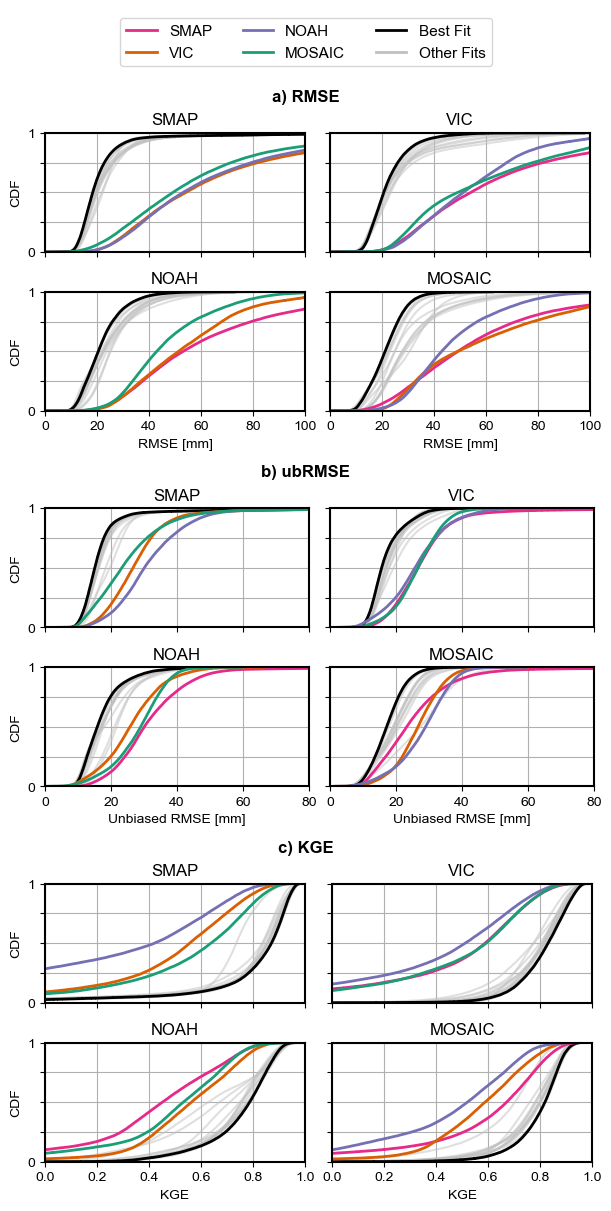

In [8]:
subset_name = 'eCONUS'
save_name = "best_only"
hindcast_dir = "best_only"
lw=2

fig = plt.figure(layout='constrained', figsize=(6, 12))
subfigs = fig.subfigures(4, 1, wspace=0.07, height_ratios = [2,10,10,10])

# Add legend
axsLegend = subfigs[0].subplots()

custom_lines = [Line2D([0], [0], color=obs_colors['SMAP'], lw=lw),
                Line2D([0], [0], color=obs_colors['VIC'], lw=lw),
                Line2D([0], [0], color=obs_colors['NOAH'], lw=lw),
                Line2D([0], [0], color=obs_colors['MOSAIC'], lw=lw),
                Line2D([0], [0], color='black', lw=lw),
                Line2D([0], [0], color='silver', lw=lw)]
axsLegend.legend(custom_lines, ['SMAP', 'VIC', 'NOAH', 'MOSAIC', 'Best Fit', 'Other Fits'],
                ncols=3, fontsize=11, loc='center')
axsLegend.axis('off')

axsTop = subfigs[1].subplots(2, 2, sharey=True, sharex=True)
subfigs[1].suptitle('a) RMSE', fontweight='bold')

axsMiddle = subfigs[2].subplots(2, 2, sharey=True, sharex=True)
subfigs[2].suptitle('b) ubRMSE', fontweight='bold')

axsBottom = subfigs[3].subplots(2, 2, sharey=True, sharex=True)
subfigs[3].suptitle('c) KGE', fontweight='bold')

##############
# RMSE
##############
stat_name = "rmse"
xlabel = "RMSE [mm]"
legend_loc = False

plot_hist_stat_all(subset_name=subset_name,
                   stat_name=stat_name,
                   hindcast_dir=hindcast_dir,
                   save_name=save_name,
                   legend_loc=legend_loc,
                   xlabel=xlabel,
                   xlims=[0,100],
                   show_other_obs=True,
                   axs=axsTop.flatten())

##############
# ubRMSE
##############
stat_name = "ubrmse"
xlabel = "Unbiased RMSE [mm]"
legend_loc = False

plot_hist_stat_all(subset_name=subset_name,
                   stat_name=stat_name,
                   hindcast_dir=hindcast_dir,
                   save_name=save_name,
                   legend_loc=legend_loc,
                   xlabel=xlabel,
                   xlims=[0,80],
                   show_other_obs=True,
                   axs=axsMiddle.flatten())

##############
# KGE
##############
stat_name = "kge"
xlabel = "KGE"
legend_loc = False

plot_hist_stat_all(subset_name=subset_name,
                   stat_name=stat_name,
                   hindcast_dir=hindcast_dir,
                   save_name=save_name,
                   legend_loc=legend_loc,
                   xlabel=xlabel,
                   xlims=[0,1],
                   show_other_obs=True,
                   axs=axsBottom.flatten())

plt.savefig('../figs/main/fig4_calibration_ecdfs.pdf', bbox_inches = 'tight')

## Coverage

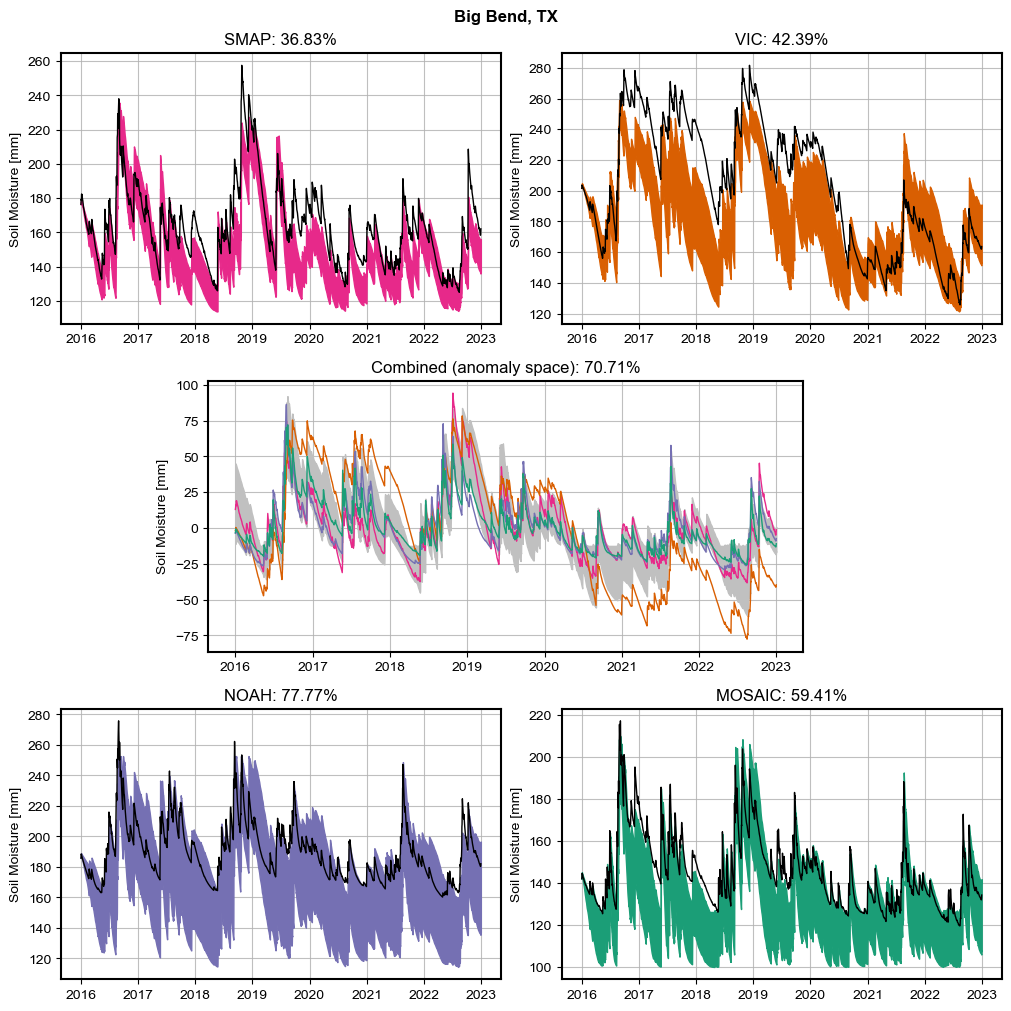

In [8]:
#################
# TIMESERIES PLOT
#################
subset_name = 'eCONUS'
save_name = 'best_only'
hindcast_dir = 'best_only'

# # McLean County IL
# lat1, lon1 = 40.61752192312278, -88.68366477345201

# Big Bend, TX
lat1, lon1 = 29.22124625856724, -103.22586554830667

fig = plt.figure(layout='constrained', figsize=(10, 10))
subfigs = fig.subfigures(3, 1, wspace=0.01)

# fig.suptitle('McLean County, IL', fontweight='bold')
fig.suptitle('Big Bend, TX', fontweight='bold')

axsTop = subfigs[0].subplots(1, 2, sharex=True, sharey=False,
                              gridspec_kw=dict(wspace=0.02, hspace=0.02))
axsTop = axsTop.flatten()

axsBottom = subfigs[2].subplots(1, 2, sharex=True, sharey=False,
                              gridspec_kw=dict(wspace=0.02, hspace=0.02))
axsBottom = axsBottom.flatten()

axMiddle = subfigs[1].subplots()
axMiddle.axis('off')
axMiddleins = axMiddle.inset_axes(bounds=[0.2, 0.0, 0.6, 1.0])

###############
# Individual
###############

for ido, obs_name in enumerate(['SMAP', 'VIC', 'NOAH', 'MOSAIC']):
    if ido < 2:
        ax = axsTop[ido]
    else:
        ax = axsBottom[ido - 2]
    # Read
    ds_mins = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/mins_{save_name}.nc")
    ds_mins = ds_mins.sel(lat=lat1, lon=lon1, method='nearest')
    ds_maxs = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/maxs_{save_name}.nc")
    ds_maxs = ds_maxs.sel(lat=lat1, lon=lon1, method='nearest')

    ds_obs = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc")
    ds_obs = ds_obs.sel(lat=lat1, lon=lon1, method='nearest')
    times = ds_obs.indexes['time'].to_datetimeindex(unsafe=True)
    # Plot
    ax.fill_between(x = times,
                    y1 = ds_mins['soilMoist'].to_numpy(),
                    y2 = ds_maxs['soilMoist'].to_numpy(),
                    color=obs_colors[obs_name])

    ax.plot(times, ds_obs['soilMoist'].to_numpy(), color='black', lw=1)
    
    # Tidy
    ds_coverage = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/coverage_{save_name}.nc")
    ds_coverage = ds_coverage.sel(lat=lat1, lon=lon1, method='nearest')['coverage'].values
    ax.set_title(f"{obs_name}: {ds_coverage:.2f}%")
    
    ax.grid(alpha=0.8)
    ax.set_axisbelow(True)
    ax.set_ylabel('Soil Moisture [mm]')

###############
# Combined
###############
ax = axMiddleins

# Read
ds_mins = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/combined/centered_mins_combined_{save_name}.nc")
ds_mins = ds_mins.sel(lat=lat1, lon=lon1, method='nearest')
ds_maxs = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/combined/centered_maxs_combined_{save_name}.nc")
ds_maxs = ds_maxs.sel(lat=lat1, lon=lon1, method='nearest')

ax.fill_between(x = times,
                y1 = ds_mins['soilMoist'].to_numpy(),
                y2 = ds_maxs['soilMoist'].to_numpy(),
                color='silver')

for ido, obs_name in enumerate(['SMAP', 'VIC', 'NOAH', 'MOSAIC']):
    ds_obs = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc")
    ds_obs = ds_obs.sel(lat=lat1, lon=lon1, method='nearest')
    ds_obs = ds_obs - ds_obs.mean(dim='time')
    ax.plot(times, ds_obs['soilMoist'].to_numpy(), color=obs_colors[obs_name], lw=1)

# Tidy
ds_coverage = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/combined/ubcoverage_combined_{save_name}.nc")
ds_coverage = ds_coverage.sel(lat=lat1, lon=lon1, method='nearest')['coverage'].values
ax.set_title(f"Combined (anomaly space): {ds_coverage:.2f}%")
    
ax.grid(alpha=0.8)
ax.set_axisbelow(True)

ax.set_ylabel('Soil Moisture [mm]')

# plt.savefig('../figs/main/fig5_mclean_coverage.pdf', bbox_inches='tight')
plt.savefig('../figs/si/bigbend_coverage.pdf', bbox_inches='tight')

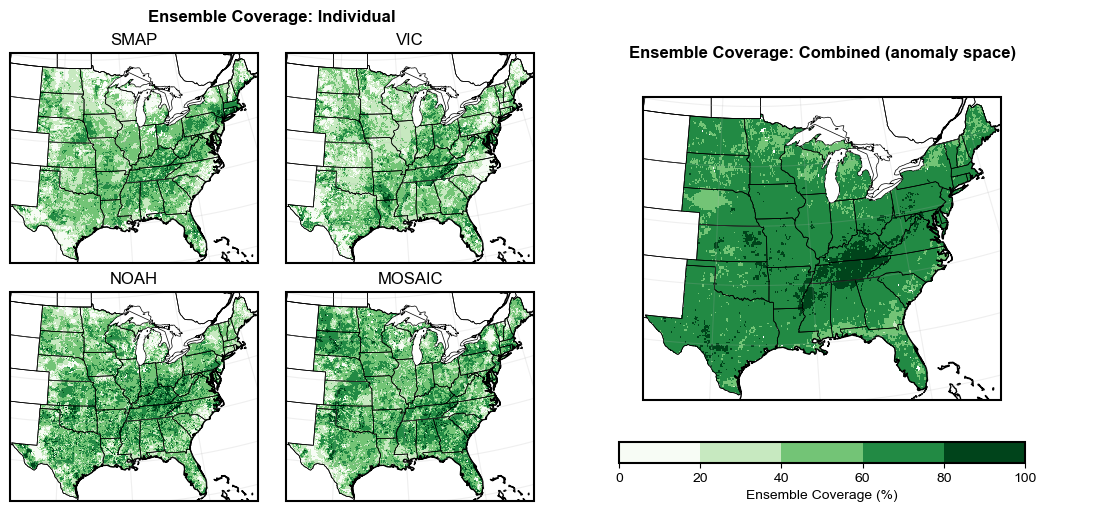

In [6]:
#################
# MAP PLOT
#################
subset_name = 'eCONUS'
save_name = 'best_only'
hindcast_dir = 'best_only'

fig = plt.figure(layout='constrained', figsize=(11, 5))
subfigs = fig.subfigures(1, 2, wspace=0.)

axsLeft = subfigs[0].subplots(2, 2, sharex=True, sharey=True,
                              gridspec_kw=dict(wspace=0.02, hspace=0.02),
                              subplot_kw=dict(projection=ccrs.LambertConformal()))

subfigs[0].suptitle('Ensemble Coverage: Individual', fontweight='bold')

axRight = subfigs[1].subplots(subplot_kw=dict(projection=ccrs.LambertConformal()))
axRight.axis('off')

axRightins = axRight.inset_axes(bounds=[0.1, 0.1, 0.8, 0.8],
                                projection=ccrs.LambertConformal())
subfigs[1].suptitle('Ensemble Coverage: Combined (anomaly space)', fontweight='bold', y=0.92)

###############
# Individual
###############
axs = axsLeft.flatten()

for ido, obs_name in enumerate(['SMAP', 'VIC', 'NOAH', 'MOSAIC']):
    # Read
    ds_coverage = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/hindcasts/{hindcast_dir}/stats/coverage_{save_name}.nc")
    ax = axs[ido]
    # Plot
    p = ds_coverage['coverage'].plot(ax=ax, vmin=0, vmax=100,
                                     cmap = 'Greens', levels=6,
                                     add_colorbar=False,
                                     transform=ccrs.PlateCarree())
    ax.set_title(obs_name)
    # Tidy
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.set_extent([-106, -73.5, 25, 49], ccrs.Geodetic())

for ax in axs:
    ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)

# Cbar
# fig.colorbar(p,
#              orientation="horizontal",
#             label="Ensemble Coverage (%)",
#             ax=axs, pad=0.04, shrink=0.5)

###############
# Combined
###############
ax = axRightins

# Read
ds_coverage = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/combined/ubcoverage_combined_{save_name}.nc")

# Plot
p = ds_coverage['coverage'].plot(ax=ax, vmin=0, vmax=100,
                                cmap = 'Greens', levels=6,
                                add_colorbar=False,
                                transform=ccrs.PlateCarree())

# Tidy
ax.coastlines()
ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
ax.set_extent([-106, -73.5, 25, 49], ccrs.Geodetic())
ax.set_title('')

# Cbar
fig.colorbar(p,
             orientation="horizontal",
             label="Ensemble Coverage (%)",
             ax=axRight, pad=0.01, shrink=0.75)

plt.savefig('../figs/main/fig6_map_coverage.png', dpi=600, bbox_inches='tight')

## Params

In [5]:
# Load all
subset_name = 'eCONUS'
loss_metric = 'pred_loss'
best_metric = True

metrics_include = ['kge', 'nse', 'taylor',
                   'rmse', 'ubrmse',
                   'mae', 'ubmae', 
                   'mse', 'ubmse',
                   'outer20rmse', 'outer20ubrmse',
                   'outer50rmse', 'outer50ubrmse']

df_all = []
for obs_name in ['SMAP', 'VIC', 'NOAH', 'MOSAIC']:
    df_tmp = get_training_res(subset_name, obs_name, loss_metric, metrics_include, best_metric)
    df_tmp['obs_name'] = obs_name
    df_all.append(df_tmp)

df_all = pd.concat(df_all)

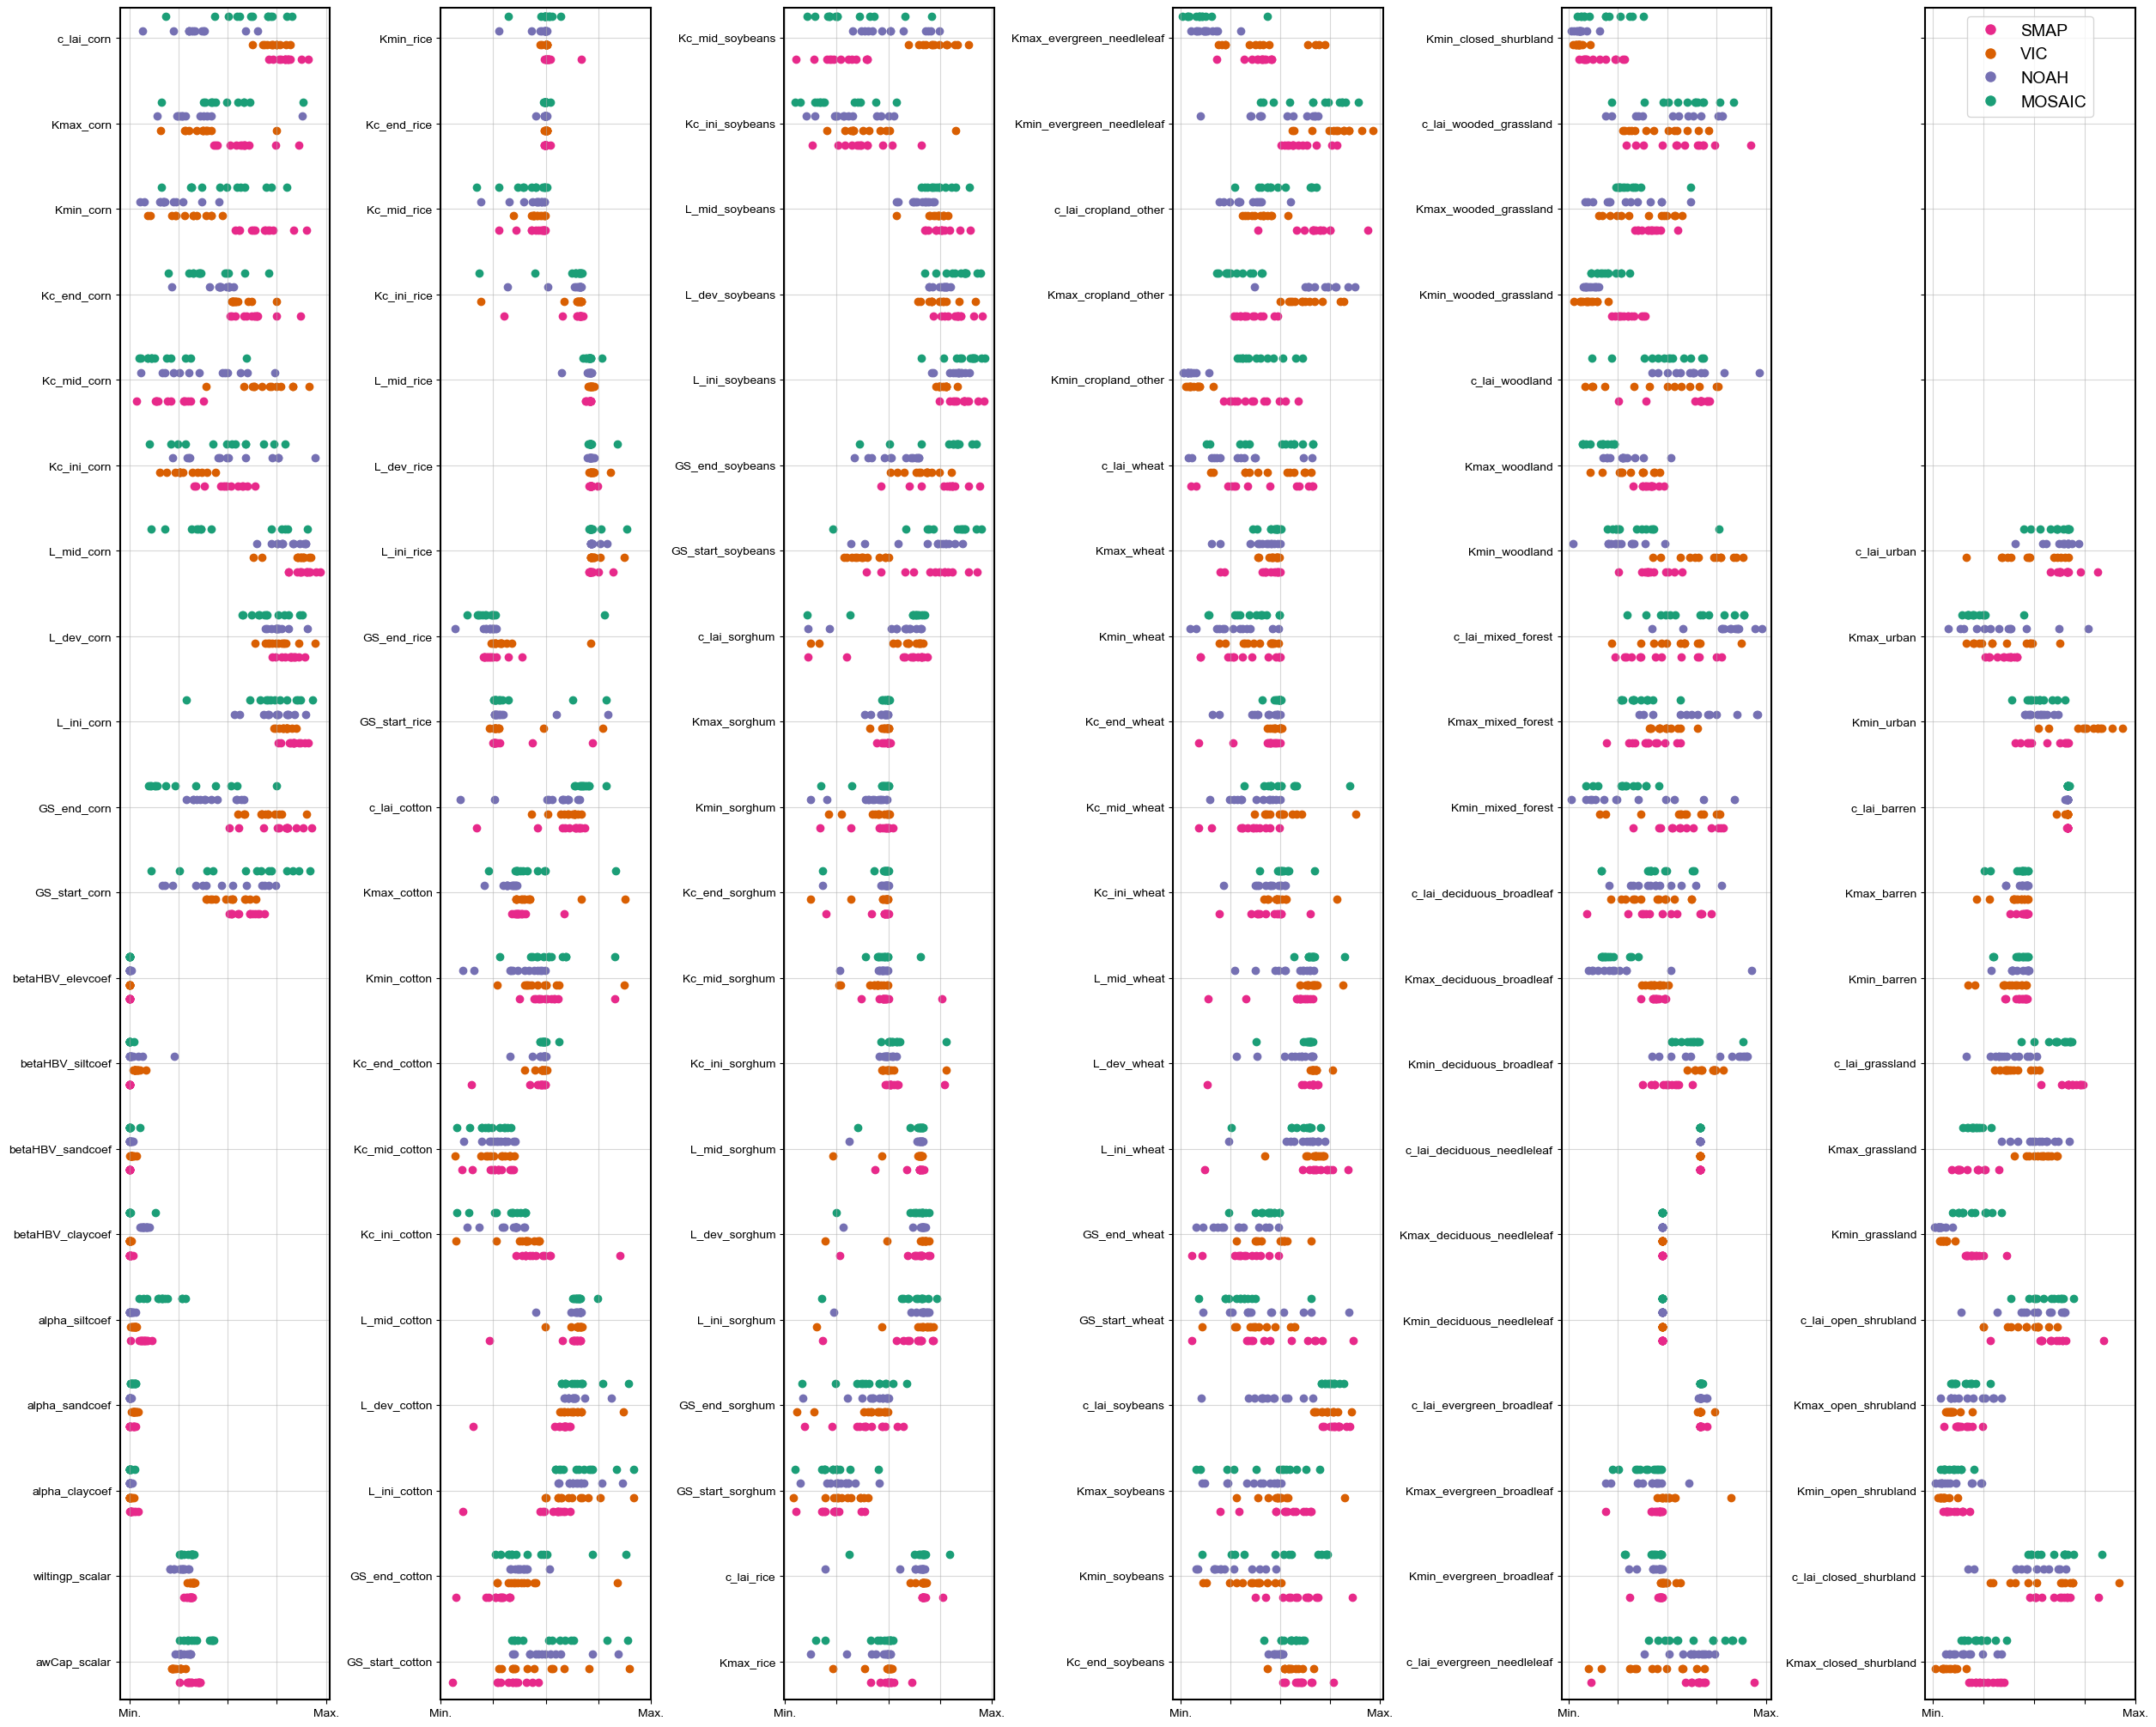

In [24]:
fig, axs = plt.subplots(1,6, figsize=(25,20), layout='constrained')

# Loop through all params
for idp, param in enumerate(param_names):
    # Column counter
    idcol = idp // 20
    ax = axs[idcol]
    for ido, obs_name in enumerate(['SMAP', 'VIC', 'NOAH', 'MOSAIC']):
        # Select data
        df_obs_sel = df_all[df_all['obs_name'] == obs_name]
        # Scale
        param_scaled = (np.exp(df_obs_sel[param]) - np.exp(params_lower[idp])) / (np.exp(params_upper[idp]) - np.exp(params_lower[idp]))
        # param_scaled = np.exp(df_obs_sel[param]) / np.exp(initial_params[idp])
        # Plot
        ax.scatter(x=param_scaled, y=[(idp % 20) + (ido/6)]*len(df_obs_sel), color=obs_colors[obs_name], marker='o')
    # Correct labels
    if idcol == 5:
        ax.set_yticks(ticks=np.arange(20)+1.5/6,
                      labels=param_names[-14:] + [""]*6) 
    else:
        ax.set_yticks(ticks=np.arange(20)+1.5/6,
                  labels=param_names[(20*idcol):(20*(idcol+1))])

for ax in axs:
    ax.grid(alpha=0.5)
    ax.set_ylim([-0.2,19.6])
    # ax.set_xticks(ticks=[0., 1., 2., 3., 4., 5.], labels=["0.", "1.", "2.", "3.", "4.", "5."])
    ax.set_xticks(ticks=[0., 0.25, 0.5, 0.75, 1.], labels=["Min.", "", "", "", "Max."])
    # ax.set_xlim([-0.25,5.25])
    # ax.set_xlabel('Multiple of default starting value')

custom_lines = [Line2D([0], [0], color='w', markerfacecolor=obs_colors['SMAP'], marker='o', markersize=10),
                    Line2D([0], [0], color='w', markerfacecolor=obs_colors['VIC'], marker='o', markersize=10),
                    Line2D([0], [0], color='w', markerfacecolor=obs_colors['NOAH'], marker='o', markersize=10),
                    Line2D([0], [0], color='w', markerfacecolor=obs_colors['MOSAIC'], marker='o', markersize=10)]
axs[-1].legend(custom_lines, ['SMAP', 'VIC', 'NOAH', 'MOSAIC'],
                ncols=1, fontsize=14, loc='upper center')
    
    
plt.savefig('../figs/param_posteriors_minmax.pdf', bbox_inches='tight')
# plt.show()

# Old

In [7]:
# Plotting function
def plot_jax_map(subset_name, obs_name, metric, iden, plot_type, cbar, title, ax):
    """
    Plots the RMSE, coverage, or linear correlation map for a given obs-product.
    """

    # Get obs
    obs = np.load(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.npy")
    # Construct xr 
    ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc")
    lons = ds_grid.lon
    lats = ds_grid.lat
    nt = obs.shape[2]
    ds_obs = xr.Dataset(
        data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(obs.reshape(len(lons), len(lats), nt), (2,1,0)))),
        coords=dict(
            lon=lons,
            lat=lats,
            time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))
    ds_obs = ds_obs['soilMoist']
    ds_obs = ds_obs.where(~ds_obs.isnull().any(dim='time'))
    
    # Get top params
    df_params = get_jax_top(subset_name, obs_name, metric, iden)
    
    if plot_type == 'coverage': 
        maxs = np.zeros(ds_obs.shape)
        mins = np.ones(ds_obs.shape) * 1000
    
        # Get ensemble bounds
        for index in range(len(df_params)):
            # Simulate
            ds_tmp = xr.open_dataset(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/training_out/{str(thresh)}thresh_{str(index)}.nc')['soilMoist']
            
            # Iterativalely calculate bounds
            maxs = np.max([maxs, ds_tmp.to_numpy()], axis=0)
            mins = np.min([mins, ds_tmp.to_numpy()], axis=0)
    
        # Get coverage
        coverage = 100 * (1 - ((((ds_obs.to_numpy() > maxs).sum(axis=0) + (ds_obs.to_numpy() < mins).sum(axis=0))) / ds_obs.shape[0]))

        # Construct ds for coverage
        ds_coverage = xr.Dataset(
            data_vars=dict(coverage=(["lat", "lon"], np.ma.masked_array(coverage, np.isnan(maxs[0,:,:])))),
            coords=dict(
                lon=lons,
                lat=lats))

        # Plot coverage
        # cmap = matplotlib.cm.Greens
        # cmap.set_bad('silver',1.)
        p = ds_coverage.coverage.plot(ax=ax, vmin=0, vmax=100, cmap = 'Greens', add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label=f"Coverage (%) from ensemble of {len(df_params)}",
                     ax=ax,
                     pad=0.04)
    elif plot_type == 'rmse':
        # Get best RMSE param
        theta_best_rmse = jnp.array([float(df_params.query("metric == 'rmse'").sort_values(by=metric).iloc[0][param]) for param in param_names])
        ds_best = simulate_jax(subset_name, obs_name, theta_best_rmse)['soilMoist']
        # Plot best RMSE
        ds_rmse = np.sqrt(((ds_best - ds_obs)**2).mean(dim='time'))
        # cmap = matplotlib.cm.Oranges
        # cmap.set_bad('silver',1.)
        p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = 'Oranges', transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label="Best RMSE [mm]",
                     ax=ax,
                     pad=0.04)
    elif plot_type == 'corr':
        # Get best RMSE param
        theta_best_rmse = jnp.array([float(df_params.query("metric == 'rmse'").sort_values(by=metric).iloc[0][param]) for param in param_names])
        ds_best = simulate_jax(subset_name, obs_name, theta_best_rmse)['soilMoist']
        # Plot best correlation
        ds_corr = xr.corr(ds_best, ds_obs, dim='time')
        p = ds_corr.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, levels=21, cmap = "RdBu", transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label="Best correlation",
                     ax=ax,
                     pad=0.04)

    # Tidy
    ax.coastlines()
    ax.set_title(title)
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

    return p

In [8]:
###############
# CONUS
###############

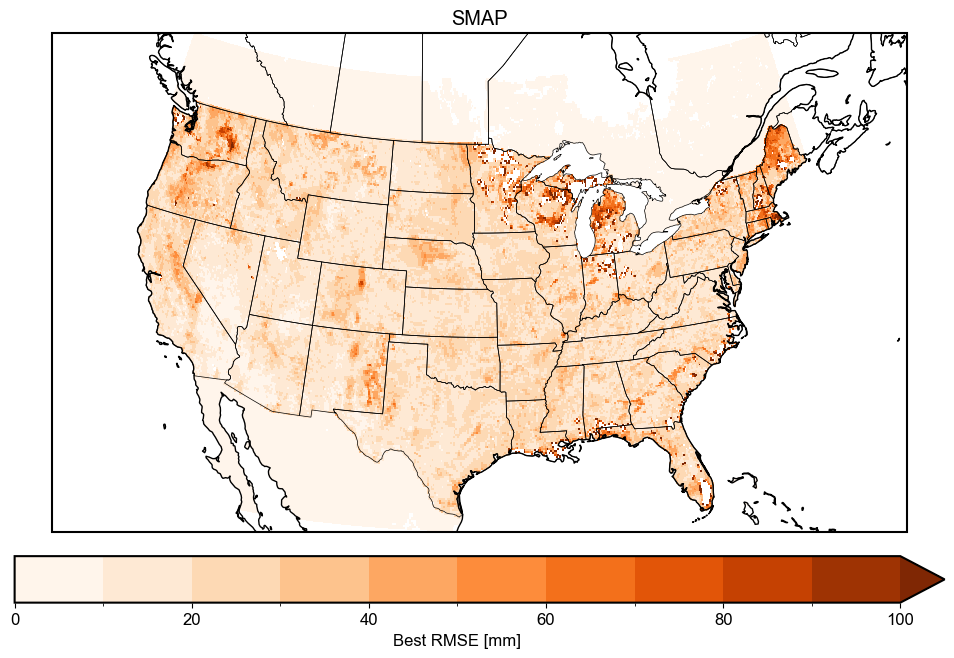

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))
plot_jax_map('CONUS', 'SMAP', 'pred_loss', '*', 'rmse', True, 'SMAP', ax)
plt.show()

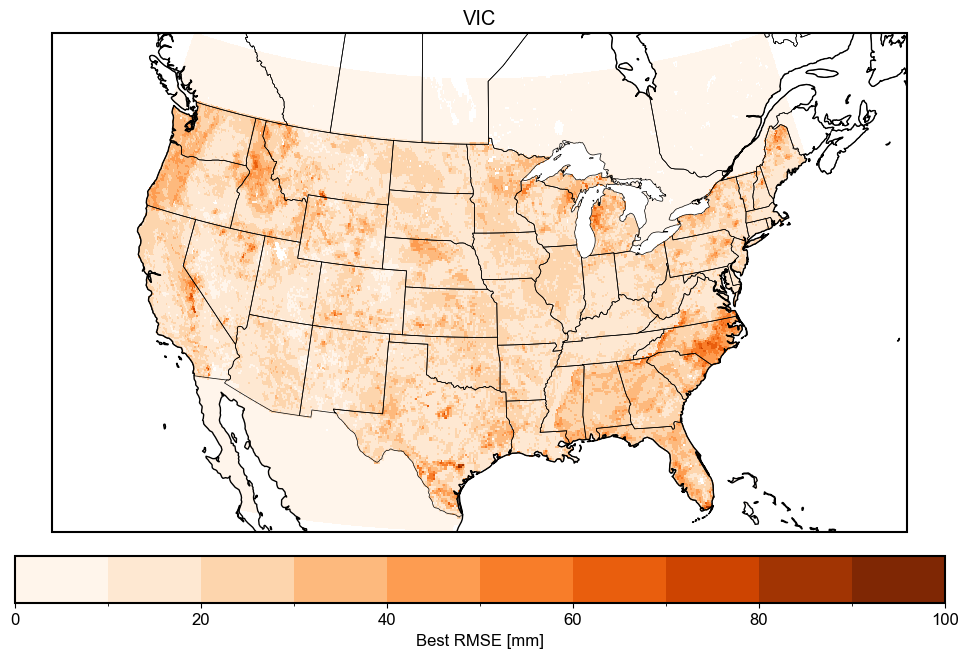

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))
plot_jax_map('CONUS', 'VIC', 'pred_loss', '*', 'rmse', True, 'VIC', ax)
plt.show()

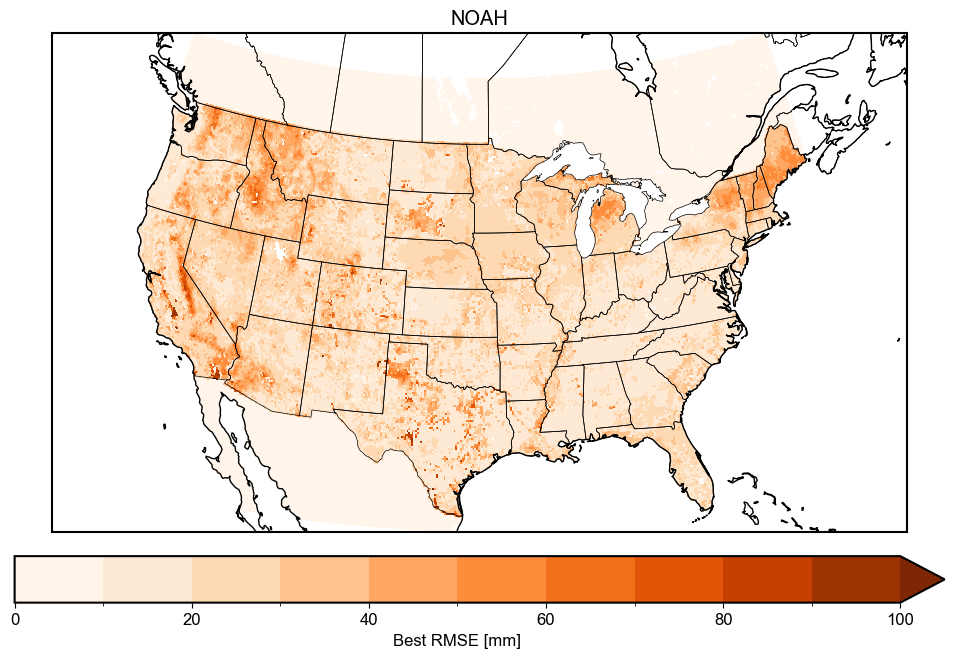

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))
plot_jax_map('CONUS', 'NOAH', 'pred_loss', '*', 'rmse', True, 'NOAH', ax)
plt.show()

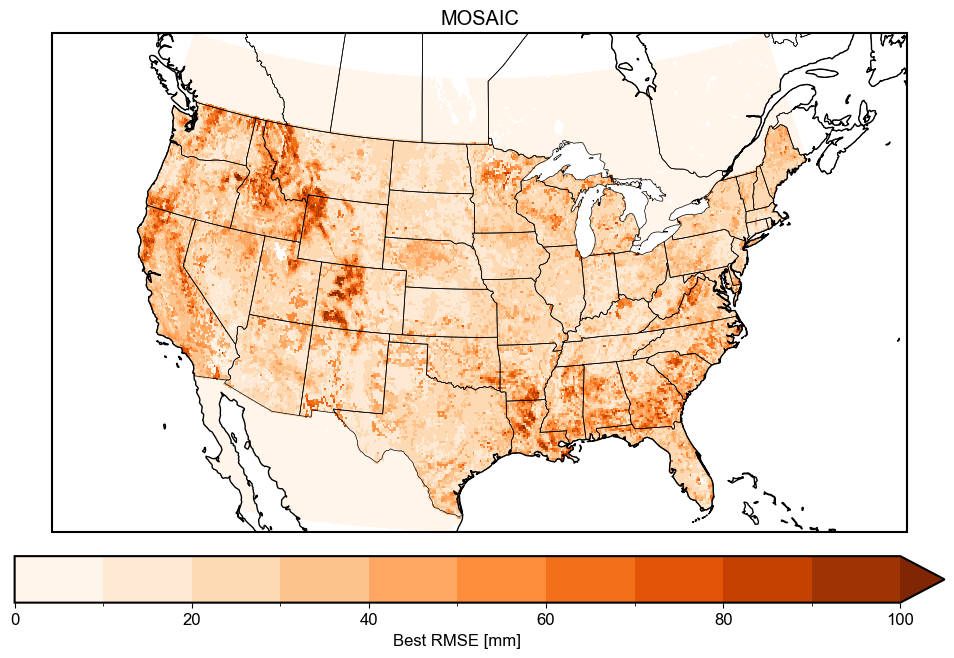

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))
plot_jax_map('CONUS', 'MOSAIC', 'pred_loss', '*', 'rmse', True, 'MOSAIC', ax)
plt.show()